In [22]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from torch.utils.data import Subset, Dataset

import pytorch_lightning as pl

pl.seed_everything(42)

Seed set to 42


42

In [23]:
IMG_SIZE = 128     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 32  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

device = torch.device('cuda')

In [24]:
import os
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations, attr, img_dir, transform=None):
        self.img_labels = annotations
        self.attr = attr
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx])
        
        image = read_image(img_path)
        label = self.img_labels[idx]

        if self.transform:
            image = self.transform(image)

        val = ""
        for i in range(self.attr[idx].__len__()):
            val = val + self.attr[idx][i].__str__()

        return image, val

In [25]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

all_attr = pd.read_csv("/home/maxim/Downloads/archive (2)/list_attr_celeba.csv", index_col="image_id")
all_attr[all_attr.columns] = (all_attr[all_attr.columns] + 1) / 2

id = pd.read_csv("/home/maxim/Downloads/archive (2)/list_attr_celeba.csv").pop("image_id")

# "Male", "Blond_Hair", "Black_Hair", "Brown_Hair",
# "No_Beard", "Young", "Bald",
# "Eyeglasses", "Gray_Hair", "Mustache", "Smiling"

# TAKE BEARD, MUSTACHE, AND EYGLASSES FOR NEXT TRAIN CYCLE

# male smiling blonde black brown bangs nobeard young

attr_list = ["Male", "Smiling", "Young", "Blond_Hair", "Black_Hair", "Brown_Hair", "Bangs", "No_Beard"]

data = CustomImageDataset(id, all_attr[
                                        attr_list
                                      ].astype(int).values,
                                               "/home/maxim/Downloads/archive (2)/img_align_celeba/img_align_celeba",
                                                 transform)

# all_trainset = torchvision.datasets.ImageFolder(root="/home/maxim/Downloads/archive (2)/img_align_celeba",
#                                          transform=transform)


# trainset = Subset(all_trainset, all_attr.to(dtype=torch.long))

# trainset.indices = all_attr.to(dtype=torch.long)

trainloader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, num_workers=20)

In [26]:
next(iter(trainloader))

[tensor([[[[-0.8902, -0.8902, -0.8902,  ..., -0.9059, -0.9059, -0.9059],
           [-0.8902, -0.8902, -0.8902,  ..., -0.9059, -0.9059, -0.9059],
           [-0.8902, -0.8902, -0.8902,  ..., -0.9059, -0.9059, -0.9059],
           ...,
           [-0.0588, -0.0510, -0.0510,  ..., -0.7098, -0.7020, -0.6941],
           [-0.0275, -0.0196, -0.0196,  ..., -0.7020, -0.7255, -0.7569],
           [-0.0196, -0.0196, -0.0118,  ..., -0.6471, -0.7020, -0.7333]],
 
          [[-0.8275, -0.8275, -0.8275,  ..., -0.8431, -0.8431, -0.8431],
           [-0.8275, -0.8275, -0.8275,  ..., -0.8431, -0.8431, -0.8431],
           [-0.8275, -0.8275, -0.8275,  ..., -0.8431, -0.8431, -0.8431],
           ...,
           [-0.0275, -0.0196, -0.0196,  ..., -0.7569, -0.7490, -0.7333],
           [ 0.0039,  0.0118,  0.0118,  ..., -0.7647, -0.7961, -0.8196],
           [ 0.0118,  0.0118,  0.0196,  ..., -0.7098, -0.7804, -0.8118]],
 
          [[-0.4431, -0.4431, -0.4431,  ..., -0.4745, -0.4745, -0.4745],
           [-

In [27]:
num_attr = attr_list.__len__()

In [28]:
num_attr

8

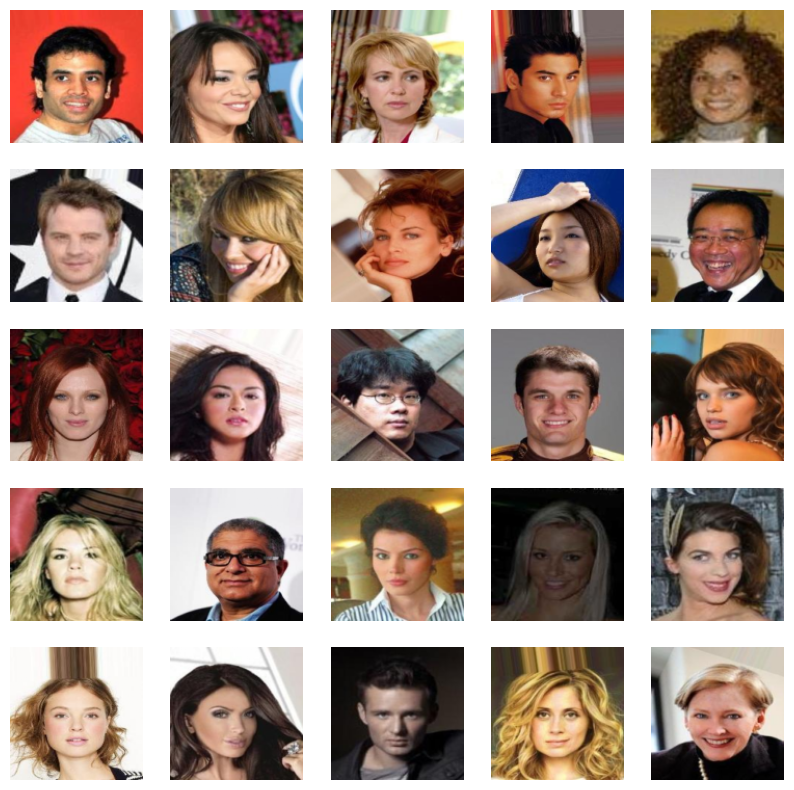

In [29]:
def cvtImg(img):
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

x, _ = next(iter(trainloader))
show_examples(x)

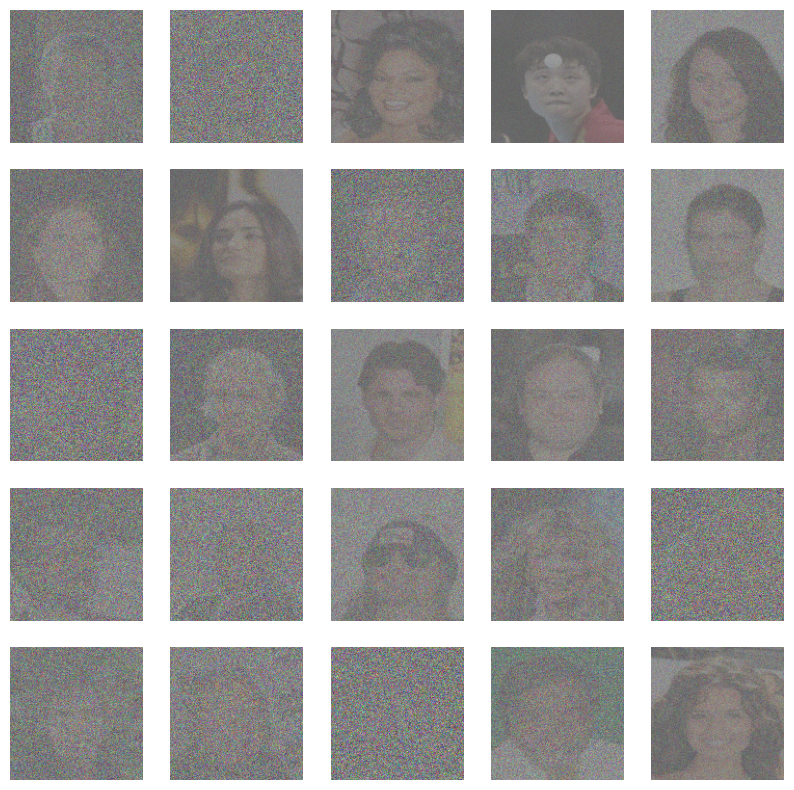

In [30]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # random for training data
x, _ = next(iter(trainloader))
a, b = forward_noise(x[:25], t)
show_examples(a)

In [31]:
class Block(nn.Module):
    def __init__(self, in_channels=128, size=128):
        super(Block, self).__init__()
        
        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

In [32]:
from datetime import datetime

In [33]:
class Model(pl.LightningModule):
    def __init__(self, num_emb = num_attr, num_classes = 2):
        super().__init__()

        self.step = 0

        self.cur_loss = 0

        self.val_check_interval = 1000

        self.num_classes = num_classes
        self.num_emb = num_emb

        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )
        
        # self.down_x512 = Block(in_channels=3, size=128)
        self.down_x256 = Block(in_channels=3, size=128)
        self.down_x128 = Block(size=64)
        self.down_x64 = Block(size=32)
        self.down_x32 = Block(size=16)
        self.down_x16 = Block(size=8)
        self.down_x8 = Block(size=4)
        # self.down_x4 = Block(size=4)
        
        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),
            
            nn.Linear(128, 32 * 4 * 4), # make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )
        
        # self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=32 + 128, size=4)
        self.up_x16 = Block(in_channels=256, size=8)
        self.up_x32 = Block(in_channels=256, size=16)
        self.up_x64 = Block(in_channels=256, size=32)
        self.up_x128 = Block(in_channels=256, size=64)
        self.up_x256 = Block(in_channels=256, size=128)
        # self.up_x512 = Block(in_channels=256, size=128)
        
        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)

        self.label_embs = []
        for i in range(num_emb):
            self.label_embs.append(nn.Embedding(self.num_classes, 192).to(device=device))
    
    def forward(self, x, x_ts, y):
        x_ts = torch.nan_to_num(self.l_ts(x_ts), 0, 0.9999, 0)

        if y is not None:
            x_ts_y = x_ts
            for i in range(self.num_emb):
                x_ts_y = x_ts_y + torch.nan_to_num(self.label_embs[i](torch.Tensor([int(y[i])]).to(device=device, dtype=torch.long)), 0, 0.9999, 0)
        else:
            x_ts_y = x_ts

        # ----- left ( down ) -----
        blocks = [
            # self.down_x512,
            self.down_x256,
            self.down_x128,
            self.down_x64,
            self.down_x32,
            self.down_x16,
            self.down_x8,
            # self.down_x4,
        ]
        
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts_y)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)
                
        # ----- MLP -----
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts_y], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)
        
        # ----- right ( up ) -----
        blocks = [
            # self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
            self.up_x64,
            self.up_x128,
            self.up_x256,
            # self.up_x512,
        ]
        
        for i, block in enumerate(blocks):
            # cat left
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)
            
            x = block(x, x_ts_y)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')
                
        # ----- output -----
        x = self.cnn_output(x)

        return torch.nan_to_num(x, 0, 0.9999, -0.9999)
    
    def configure_optimizers(self):
        self.optim = torch.optim.Adam(self.parameters(), lr=0.0008)
        
        return {'optimizer': self.optim}
    
    def training_step(self, batch, batch_idx):
        x, labels = batch

        x_ts = generate_ts(len(x[0]))
        x_a, x_b = forward_noise(x[0].cpu().numpy(), x_ts)
        x_a = torch.from_numpy(x_a).to(device=device)
        x_b = torch.from_numpy(x_b).to(device=device)
        
        x_ts = torch.from_numpy(x_ts).view(-1, 1).float()
        x_ts = x_ts.to(device=device)

        x_a = x_a.float()
        x_b = x_b.float()

        if np.random.random() < 0.1:
            labels = None
        
        if labels == None:
            y_p = self(torch.nan_to_num(x_a, 0, 0.9999, -0.9999), x_ts, labels)
        else:
            y_p = self(torch.nan_to_num(x_a, 0, 0.9999, -0.9999), x_ts, labels[0])

        y_p = torch.clip(y_p, -0.9999, 0.9999)
        x_b = torch.clip(x_b, -0.9999, 0.9999)

        # print(np.isnan(y_p).any())
        # print(np.isfinite(y_p).any())
        # print(np.isnan(x_b).any())
        # print(np.isfinite(x_b).any())

        loss = torch.mean(torch.abs(y_p - x_b))

        self.step += 1

        if self.step % self.val_check_interval == 0:
            self.predict_step(batch=batch, batch_idx=batch_idx)

            now = datetime.now()

            dt_string = now.strftime("%d|%m|%Y %H:%M:%S")

            print(f"Step {self.step:03d} | Loss: {loss.item()}")
            
            dict = self.state_dict()

            dict["pytorch-lightning_version"] = '2.1.0'
            dict["global_step"] = self.step
            dict["epoch"] = self.current_epoch
            dict["state_dict"] = self.state_dict()
            
            torch.save(dict, "/home/maxim/Documents/TestProject/maxim-lightning/saves/diffusion_model" + dt_string + ".ckpt")

        logs = {"loss": loss}
        return {"loss": loss, "log": logs}
    
    def predict_step(self, batch, batch_idx):
        x, labels = batch

        xs = []
        x = torch.randn(size=(8, 3, IMG_SIZE, IMG_SIZE), device=device)

        label = labels[0]

        print(', '.join(attr_list) + " " + label.__str__() + "\n" + 
              "|\n\/")

        with torch.no_grad():
            for i in trange(timesteps + 3):
                t = i
                
                x = self(torch.nan_to_num(x, 0, 0.9999, -0.9999), torch.nan_to_num(torch.full([8, 1], t, dtype=torch.float, device=device), 0, 0.9999, -0.9999), label)

                if i % 2 == 0:
                    xs.append(x[0].cpu())
        xs = torch.stack(xs, dim=0)

        xs = torch.clip(xs, -0.9999, 0.9999)
        
        xs = torch.nan_to_num(xs, 0, 0.9999, -0.9999)
        xs = cvtImg(xs)

        plt.figure(figsize=(20, 2))
        for i in range(len(xs)):
            plt.subplot(1, len(xs), i+1)
            plt.imshow(xs[i])
            plt.title(f'{i}')
            plt.axis('off')

        plt.show()

        return x[0]

model = Model(num_classes=2, num_emb=num_attr)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name       | Type       | Params
-------------------------------------------
0  | l_ts       | Sequential | 768   
1  | down_x256  | Block      | 4.2 M 
2  | down_x128  | Block      | 1.4 M 
3  | down_x64   | Block      | 582 K 
4  | down_x32   | Block      | 385 K 
5  | down_x16   | Block      | 336 K 
6  | down_x8    | Block      | 323 K 
7  | mlp        | Sequential | 354 K 
8  | up_x8 

Training: |          | 0/? [00:00<?, ?it/s]

Male, Smiling, Young, Blond_Hair, Black_Hair, Brown_Hair, Bangs, No_Beard 00110001
|
\/


  0%|          | 0/19 [00:00<?, ?it/s]

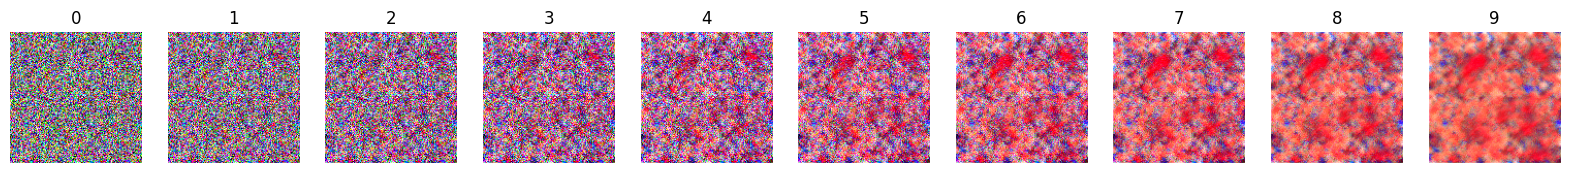

Step 1000 | Loss: 0.039284661412239075


/home/maxim/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


: 

In [34]:
trainer = pl.Trainer(accelerator=device.type, precision="16-mixed", max_epochs=500)

# model = Model.load_from_checkpoint('/home/maxim/Documents/TestProject/maxim-lightning/saves/diffusion_model04|12|2023 15:27:42.ckpt')

trainer.fit(model, train_dataloaders=trainloader)

In [ ]:
# trainer.predict(model, trainloader)